# Data Extraction

Built through **PDF Plumber** and depends on structure of the company's transcript releases - intuitive to adapt code. Consider the data in its raw form, consisting of text and \n (new lines). Normally, these are consistent for companies and therefore straightforward to implement rules to extract **dates, names,** etc. depending on where they are positioned in the format of the transcript.

For example, the dates for the below transcript form follow from 'Earnings Call' in the title. By finding the index of where that title ends: 

**date_idx = txt.find('EVENT DATE/TIME: ') + len('EVENT DATE/TIME: ')** 

We can find a range that encompasses the title and use split() to identify the month, day, year, etc.

In [ ]:
import os
import pdfplumber

In [ ]:
def transcript_convert(ticker):
    path = '...Transcripts/ALK'
    # path = os.path.join(*paths, ticker)
    pdf_list = [x for x in os.listdir(path) if x[-4:] == '.pdf']
    print(pdf_list)
    columns = ['particip', 'qna', 'transcript', 'date', 'company']
    data = pd.DataFrame(columns=columns)
    for f in pdf_list:
        found_start = False
        out = ''
        with pdfplumber.open(os.path.join(path, f)) as pdf:

            for i,v in enumerate(pdf.pages):
                curr_page = pdf.pages[i]
                txt = curr_page.extract_text()

                if i == 0:
                    if txt.find(ticker + ' -') != -1:
                        dt_idx = txt.find(ticker + ' -')
                        qt_txt = txt[dt_idx:].split('\n')
                        qt_txt = [x for x in qt_txt if x != ' '][0].strip(ticker + ' -')  # remove ' '
                    else:
                        qt_txt = [x for x in txt.split('\n') if 'Earnings' in x][0]
                    quarter = qt_txt.split()[0]
                    year = qt_txt.split()[1]
                    date_idx = txt.find('EVENT DATE/TIME: ') + len('EVENT DATE/TIME: ')
                    date_idx_end = date_idx + 50  # static character count for length of date
                    date = parse(txt[date_idx:date_idx_end].split('\n')[0]).strftime('%m-%d-%y')
                    comp_name = qt_txt.split(' Earnings Call')[0][qt_txt.split(' Earnings Call')[0].find(year)+ len(year) + 1:]

                elif i == 1:
                    corp_idx = txt.find('CORPORATE PARTICIPANTS')+len('CORPORATE PARTICIPANTS\n')
                    corp_idx_end = txt.find('\nCONFERENCE CALL PARTICIPANTS')
                    conf_idx = txt.find('CONFERENCE CALL PARTICIPANTS') + len('CONFERENCE CALL PARTICIPANTS\n')
                    conf_idx_end = txt.find('PRESENTATION')
                    corp_txt = txt[corp_idx:corp_idx_end].split('\n')
                    corp_name = [x.split(comp_name.split()[0])[0] for x in corp_txt]
                    corp_name = [x.strip() for x in corp_name if x.strip() != '']
                    corp_speaker1 = corp_name
                    corp_speaker2 = [x.split()[0] + ' ' + x.split()[1] for x in corp_txt if len(x.split()) >= 2]
                    corp_speaker3 = [x.split()[0] + ' ' + x.split()[2] for x in corp_txt if
                                     len(x.split()) >= 3]
                    corp_speaker4 = [x.split()[0] + ' ' + x.split()[1] + ' ' + x.split()[2] for x in corp_txt if
                                     len(x.split()) >= 3]

                    conf_txt = txt[conf_idx:conf_idx_end].split('\n')
                    conf_speaker1 = [x.split()[0] + ' ' + x.split()[1] for x in conf_txt if len(x.split()) >= 2]
                    conf_speaker2 = [x.split()[0] + ' ' + x.split()[2] for x in conf_txt if len(x.split()) >= 3]    # accounts for speakers with middle name
                    conf_speaker3 = [x.split()[0] + ' ' + x.split()[1] + ' ' + x.split()[2] for x in conf_txt if len(x.split()) >=3]    # accounts for speakers with middle name

                    speaker_list = corp_speaker1 + corp_speaker2 + corp_speaker3 + corp_speaker4 + conf_speaker1 + conf_speaker2 + conf_speaker3

                    columns = ['corp_particip','conf_particip']
                    df_speaker = pd.DataFrame(columns=columns)
                    corp_list = corp_speaker1 + corp_speaker2 + corp_speaker3 + corp_speaker4
                    conf_list = conf_speaker1 + conf_speaker2 + conf_speaker3
                    df_speaker['corp_particip'] = corp_list + (max(len(corp_list), len(conf_list)) -len(corp_list)) * ['']
                    df_speaker['conf_particip'] = conf_list + (max(len(corp_list), len(conf_list)) -len(conf_list)) * ['']
                    df_speaker.to_csv(os.path.join(path, ticker + '_' + date + '_speakers.csv'), index=False)

                # remove footer
                if i != 0 and i != len(pdf.pages)-1:
                    beginning_idx = txt.find('Earnings Call')+len('Earnings Call\n')
                    pg_num_idx = txt.find('\n' + str(i + 1))
                    txt = txt[beginning_idx:pg_num_idx]

                # remove disclaimer
                elif i ==len(pdf.pages)-1:  # if last page remove disclaimer
                    beginning_idx = txt.find('Earnings Call')+len('Earnings Call\n')
                    dis_idx = txt.find('DISCLAIMER')
                    txt = txt[beginning_idx:dis_idx]

                # write to file
                if found_start == True:
                    out = out+txt

                elif txt.find('PRESENTATION') != -1 and found_start == False:
                    found_start = True
                    start_idx = txt.find('PRESENTATION')+len('PRESENTATION\n')
                    out = out+txt[start_idx:]

        columns = ['particip', 'qna', 'transcript', 'date', 'company']
        df = pd.DataFrame(columns=columns)
        speaker = ''
        content = ''
        qna_start_j = 1000  # initialize
        j = 0
        for line in out.split('\n'):

            if line.find('QUESTIONS AND ANSWERS') != -1:
                qna_start_j = j + 2
            if len(line.split()) == 1:
                find_speaker = [x for x in ['Operator'] if (x in line)]
            else:
                find_speaker = [x for x in speaker_list if (x + ' -' in line)]  # + ' -'

            if find_speaker == []:
                content = content + ' ' + line
            else:
                if speaker != '':
                    if speaker in corp_list:
                        df.loc[j] = [speaker, 0, content, date, ticker]
                    else:
                        df.loc[j] = [speaker, 1, content, date, ticker]
                    content = ''
                    j += 1

                speaker = find_speaker[0]

        print(pdf.pages[0].extract_text())
        data = data.append(df)

    data.to_csv(os.path.join(path, ticker + '.csv'), index=False)
    print('converted: ' + os.path.join(path, ticker + '.csv'))

**Result is a file of multiple transcripts - by speaker, whether company personnel or external and date of the earnings call.**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
root_folder='/content/drive/My Drive/DataAnalysis'

In [4]:
data = pd.read_csv(root_folder+'/Transcripts_test.csv')
data['date'] = pd.Series(pd.to_datetime(data['date'], format='%m-%d-%y'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   particip    1058 non-null   object        
 1   qna         1058 non-null   int64         
 2   transcript  1058 non-null   object        
 3   date        1058 non-null   datetime64[ns]
 4   company     1058 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 41.5+ KB


# Data Processing and Exploratory Analysis

Clean text using regex and filter dataframe as appropriate, for example by age, by date, by topics, etc. As initial statistical analysis of text by sentences requires punctuation to be preserved, and may require grammar as well, we can only apply a light cleaner which mostly removes special characters.

In [5]:
def clean(text):
    text = re.sub('[0-9]+.\t', '', str(text)) # removing paragraph numbers
    text = re.sub('\n ', '', str(text))
    text = re.sub('\n', ' ', str(text))
    text = re.sub("'s", '', str(text))
    text = re.sub("-", ' ', str(text))
    text = re.sub("— ", '', str(text))
    text = re.sub('\"', '', str(text))
    text = re.sub("Mr\.", 'Mr', str(text))
    text = re.sub("Mrs\.", 'Mrs', str(text))
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))

    return text

In [6]:
data['Transcript_clean'] = data['transcript'].apply(clean)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058 entries, 0 to 1057
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   particip          1058 non-null   object        
 1   qna               1058 non-null   int64         
 2   transcript        1058 non-null   object        
 3   date              1058 non-null   datetime64[ns]
 4   company           1058 non-null   object        
 5   Transcript_clean  1058 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 49.7+ KB


**Considering a subset of data - namely only company personnel.**

In [ ]:
data_subset = data[data['qna'] == 0]
data_subset = data_subset.drop(['particip'], axis=1)
data_subset['year'] = pd.DatetimeIndex(data_subset['date']).year
data_subset.info()

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
import random
from collections import Counter

import string
import nltk
from nltk.tokenize import word_tokenize
import gensim
from gensim.summarization.textcleaner import split_sentences
from wordcloud import WordCloud

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [10]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('averaged_perceptron_tagger')

In [ ]:
nltk.download('universal_tagset')

In [13]:
punc = string.punctuation
stopwords = nltk.corpus.stopwords.words('english')

In [14]:
def count_stopwords(text, stopwords):
    ''' Return the number of stopwords in the text
        Input:
            - text: string
            - stopwords: list of string, containing the stopwords
        Output:
            - int, number of stopwords in the text argument
    '''
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stopwords]
    
    return len(stopwords_x)

In [15]:
data_subset['text_sent_count'] = data_subset['Transcript_clean'].apply(lambda x : len(split_sentences(x)))
data_subset['text_word_count'] = data_subset['Transcript_clean'].apply(lambda x : len(x.split()))
data_subset['text_char_count'] = data_subset['Transcript_clean'].apply(lambda x : len(x.replace(" ","")))
data_subset['text_word_density'] = data_subset['text_word_count'] / (data_subset['text_char_count'] + 1)
data_subset['text_sent_density'] = data_subset['text_sent_count'] / (data_subset['text_word_count'] + 1)
data_subset['text_punc_count'] = data_subset['Transcript_clean'].apply(lambda x : len([a for a in x if a in punc]))

# Stopwords
data_subset['text_stopw_count'] =  data_subset['Transcript_clean'].apply(lambda x : count_stopwords(x, stopwords))
data_subset['text_stopw_density'] = data_subset['text_stopw_count'] / (data_subset['text_word_count'] + 1)

In [16]:
print(data_subset[['text_word_count', 'text_char_count', 'text_word_density', 'text_punc_count']].head(5))

   text_word_count  text_char_count  text_word_density  text_punc_count
0             1653             8263           0.200024              241
1             1862             9687           0.192197              207
3              192              823           0.233010               33
4              119              548           0.216758               16
6              126              568           0.221441               14


In [17]:
data_subset[['text_sent_count', 'text_word_count', 'text_char_count', 'text_stopw_count', 'text_punc_count']].describe()

,text_sent_count,text_word_count,text_char_count,text_stopw_count,text_punc_count
count,693.000000,693.000000,693.000000,693.000000,693.000000
mean,9.666667,186.976912,866.701299,85.028860,27.636364
std,12.304306,280.925405,1386.459402,116.484732,38.471451
min,1.000000,1.000000,3.000000,0.000000,1.000000
25%,3.000000,43.000000,194.000000,21.000000,7.000000
50%,6.000000,108.000000,471.000000,53.000000,16.000000
75%,11.000000,187.000000,821.000000,92.000000,29.000000
max,85.000000,1862.000000,9687.000000,732.000000,241.000000


In [ ]:
quarters = data_subset['date'].unique()

In [ ]:
labels_dict={'sum_word_count': 'Word Count of Summaries','text_word_count': 'Word Count of Texts',
             'sum_char_count': 'Char Count of Summaries','text_char_count': 'Char Count of Texts',
             'sum_word_density': 'Word Density of Summaries','text_word_density': 'Word Density of Texts',
             'sum_punc_count': 'Punctuation Count of Summaries','text_punc_count': 'Punctuation Count of Texts',
             'text_sent_count': 'Sentence Count of Texts', 'sum_sent_count': 'Sentence Count of Summaries',
             'text_sent_density': 'Sentence Density of Texts', 'sum_sent_density': 'Sentence Density of Summaries',
             'text_stopw_count': 'Stopwords Count of Texts', 'sum_stopw_count': 'Stopwords Count of Summaries',
             'ADJ': 'adjective','ADP': 'adposition', 'ADV': 'adverb','CONJ': 'conjunction',
             'DET': 'determiner','NOUN': 'noun', 'text_unknown_count': 'Unknown words in Texts',
             'sum_unknown_count': 'Unknown words in Summaries',}

In [ ]:
def plot_boxplots(data, plot_vars, labels, figsize):
    ''' Plot a box-plot of the variables in the plot_vars list using the labels and a size of figesize
        Input:
        - data: a dataframe, containing the data points to plot
        - plot_vars: a (1,x) array, containig the columns to plot
        - labels: a dctionary, to map the column names to its label
        - figsize: a tuple, indicating the size of the figure
    '''
    
   # We need to identify is this a matrix or a vector
    if plot_vars.ndim == 1:
        nrows = 1
        ncols = plot_vars.shape[0]
    else:
        nrows= plot_vars.shape[0]
        ncols = plot_vars.shape[1]

    f, axes = plt.subplots(nrows, ncols, sharey=False, figsize=(15,5))

    for i in range(nrows):
        for j in range(ncols):
            if plot_vars[i,j]!=None:
                if axes.ndim > 1:

                    axes[i,j].set_title(labels[plot_vars[i,j]])
                    axes[i,j].grid(True)
                    #Set x ticks
                    axes[i,j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[i,j].boxplot(data[plot_vars[i,j]])
                else:

                    axes[j].set_title(labels[plot_vars[i,j]])
                    axes[j].grid(True)
                    #Set x ticks
                    axes[j].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
                    # Plot a boxplot for the column in plot_vars
                    axes[j].boxplot(data[plot_vars[i,j]])
                
            else:
                axes[i,j].set_visible(False)

    f.tight_layout()
    plt.show() 


def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

def plot_histograms(data, plot_vars, xlim, labels, figsize):

    kwargs = dict(hist_kws={'alpha':.7}, kde_kws={'linewidth':2})
    fig, axes = plt.subplots(plot_vars.shape[0], plot_vars.shape[1], figsize=figsize, sharey=False, dpi=100)

    for i in range(plot_vars.shape[1]):

        sns.distplot(data[plot_vars[0,i]] , color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1),), 
                     ax=axes[i], axlabel=labels[plot_vars[0,i]], bins= 50, norm_hist = True)
        # For a better visualization we set the x limit
        axes[i].set_xlim(left=0, right=xlim[i])
        
    fig.tight_layout()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

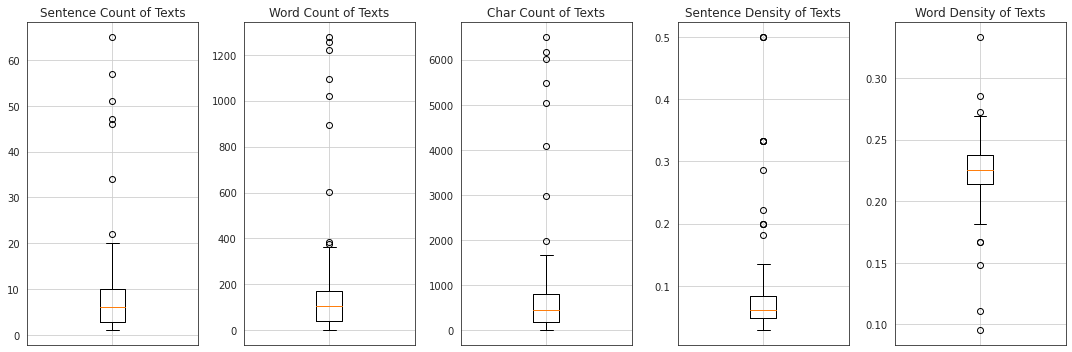

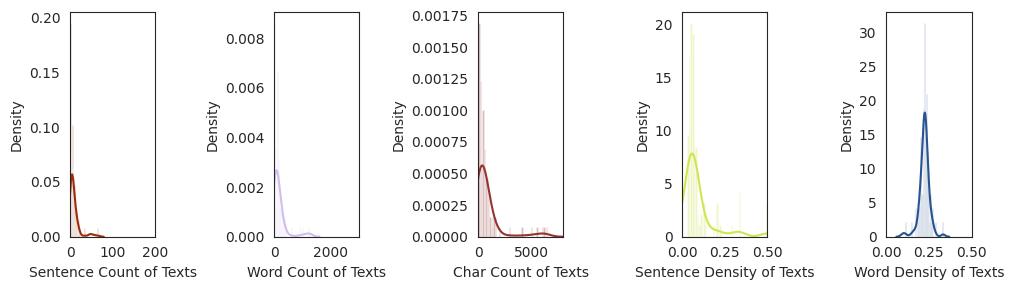

In [ ]:
# Set financial quarter to look at 
per_quarter = data_subset[data_subset['date'] == quarters[2]]
plot_vars=np.array([['text_sent_count', 'text_word_count', 'text_char_count','text_sent_density','text_word_density']])
plot_boxplots(per_quarter, plot_vars, labels_dict, figsize=(10,3))
plot_histograms(per_quarter, plot_vars, [200, 3000, 8000, 0.5, 0.5], labels_dict, figsize=(10,3))

## Part of Speech Tagging

The process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech tagging, POS-tagging, or simply tagging. Parts of speech are also known as word classes or lexical categories. The collection of tags used for a particular task is known as a tagset. Our emphasis in the next section is on exploiting tags, and tagging text automatically.

Tag Meaning English Examples:

*   ADJ, adjective: new, good, high, special, big, local
*   ADP,adposition: on, of, at, with, by, into, under
*   ADV, adverb: really, already, still, early, now
*   CONJ, conjunction: and, or, but, if, while, although
*   DET, determiner or article: the, a, some, most, every, no, which
*   NOUN, noun: year, home, costs, time, Africa
*   NUM,numeral: twenty-four, fourth, 1991, 14:24
*   PRT, particle: at, on, out, over per, that, up, with
*   PRON, pronoun: he, their, her, its, my, I, us
*   VERB, verb: is, say, told, given, playing, would
*   ., punctuation marks: . , ; !
*   X, othe: ersatz, esprit, dunno, gr8,

In [ ]:
def get_pos_tags(sentences, tagset='universal'):

    df = pd.DataFrame(columns=['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X'])
    for sent in sentences:

        pos_tags = Counter([j for i,j in nltk.pos_tag(word_tokenize(sent), tagset='universal')])
        #Appends the pos tags to the dataframe, fill NaN values with 0
        df = df.append(pos_tags, ignore_index=True).fillna(0)

    return df.astype(int)

In [ ]:
news_text = data_subset['Transcript_clean'].values
df_text = get_pos_tags(news_text)

In [ ]:
plot_vars=np.array([['ADJ','ADP','ADV','CONJ','DET','NOUN']])
plot_histograms(df_text, plot_vars, [100, 100, 50, 50, 100, 300], labels_dict, figsize=(15,5))

# Further Data Cleaning

Contraction mapping, text cleaning function, stemming and lemmatizer. Additional use of regex to remove apostrophe and [^a-zA-Z\s\-] to remove any other remaining special characters - making the distinction for "-" to be replaced by space rather than blank. Remove stopwords and a manually created function to remove short words.

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub('"', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(' ')])
    newString = re.sub(r"’s\b", "", newString)
    newString = re.sub('[^a-zA-Z\s\-]', '', newString)
    newString = re.sub('[^a-zA-Z\s]', ' ', newString)
    tokens = [w for w in newString.split() if w not in stopwords]
    long_words = []
    prev_word = []
    for i in tokens:
        if i not in prev_word and len(i) >= 3:  # removing short word
            long_words.append(i)
            prev_word = [i]
    return (" ".join(long_words)).strip()

In [ ]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# Extractive Summarization by Sentence Ranking

Concept of centroid words based on TF-IDF of text and embedding representation through the summation of the word vectors. Cosine similarity matrix between word vectors of each sentence compared to the centroid embedding representation to find "key" sentences.

In [ ]:
import nltk
import re
import string
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize as nltk_sent_tokenize
from nltk.tokenize import word_tokenize as nltk_word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
import numpy as np
from scipy.spatial.distance import cosine

In [ ]:
# nltk.download('stopwords')
# nltk.download('punkt')

In [ ]:
def similarity(v1, v2):
    score = 0.0
    if np.count_nonzero(v1) != 0 and np.count_nonzero(v2) != 0:
        score = ((1 - cosine(v1, v2)) + 1) / 2
    return score

Sentence tokenization and then cleanup of sentences (tokenize sentences and tokenize words) - for the purposes of the final summarise function.

In [ ]:
def sent_tokenize(text):
    sents = nltk_sent_tokenize(text)
    sents_filtered = []
    for s in sents:
      sents_filtered.append(s)
    return sents_filtered

In [ ]:
def cleanup_sentences(text):
    stop_words = set(stopwords.words('english'))
    sentences = sent_tokenize(text)
    sentences_cleaned = []
    for sent in sentences:
        words = nltk_word_tokenize(sent)
        words = [w for w in words if w not in string.punctuation]
        words = [w for w in words if not w.lower() in stop_words]
        words = [w.lower() for w in words]
        sentences_cleaned.append(" ".join(words))
    return sentences_cleaned

**NLTK word tokenize**

In [ ]:
# Populate word vector with all embeddings.
# This word vector is a look up table that is used
# for getting the centroid and sentences embedding representation.
def word_vectors_cache(sentences, embedding_model):
    word_vectors = dict()
    for sent in sentences:
        words = nltk_word_tokenize(sent)
        for w in words:
            word_vectors.update({w: embedding_model.wv[w]})
    return word_vectors

The algorithm uses TF-IDF to find the most relevant words of the text. These words are the centroid of the text. Then the vectors of the words that are part of the centroid are summed as an embedding representation of the centroid.

In [ ]:
def get_tf_idf(sentences):
    vectorizer = CountVectorizer()
    sent_word_matrix = vectorizer.fit_transform(sentences)
    transformer = TfidfTransformer(norm=None, sublinear_tf=False, smooth_idf=False)
    tfidf = transformer.fit_transform(sent_word_matrix)
    tfidf = tfidf.toarray()

    centroid_vector = tfidf.sum(0)
    centroid_vector = np.divide(centroid_vector, centroid_vector.max())

    feature_names = vectorizer.get_feature_names()
    # feature_names = vectorizer.get_feature_names_out()

    relevant_vector_indices = np.where(centroid_vector > 0.3)[0]
    word_list = list(np.array(feature_names)[relevant_vector_indices]) # get centroid words
    return word_list

In [ ]:
def build_embedding_rep(words, word_vectors, embedding_model):
    embedding_representation = np.zeros(embedding_model.vector_size, dtype="float32") # vocabulary size of text
    word_vectors_keys = set(word_vectors.keys()) # alphabetical order or vocabulary in word form (keys of word vectors)
    count = 0
    for w in words:
      if w in word_vectors_keys: # lookup against key to extract the correct corresponding word vector
        embedding_representation = embedding_representation + word_vectors[w] # sum of loop
        count += 1
      if count != 0:
        embedding_representation = np.divide(embedding_representation, count)
      return embedding_representation

Finally, bring everything together...

In [ ]:
def summarize(text, embedding_model):
    raw_sentences = sent_tokenize(text) # tokenize sentence with NLTK
    clean_sentences = cleanup_sentences(text) # cleanup by removing stopwords, etc.

    centroid_words = get_tf_idf(clean_sentences) # centroid of all cleaned sentences (i.e. whole text)
    # print(len(centroid_words), centroid_words)

    word_vectors = word_vectors_cache(clean_sentences, embedding_model)

    centroid_vector = build_embedding_rep(centroid_words, word_vectors, embedding_model)

    sentences_scores = []
    for i in range(len(clean_sentences)):
        scores = []
        words = clean_sentences[i].split()
        sentence_vector = build_embedding_rep(words, word_vectors, embedding_model)
        # similarity between sentence embedding vector and centroid embedding vector
        score = similarity(sentence_vector, centroid_vector)
        sentences_scores.append((i, raw_sentences[i], score, sentence_vector))
      
    sentence_scores_sort = sorted(sentences_scores, key=lambda x: x[2], reverse=True)

    # for s in sentence_scores_sort:
    #    print(s[0], s[1], s[2])
    count = 0
    sentences_summary = []

    # Handle redundancy
    for s in sentence_scores_sort:
        if count > 100:
            break
        include_flag = True
        for ps in sentences_summary:
            sim = similarity(s[3], ps[3])
            if sim > 0.95:
                include_flag = False
        if include_flag:
            sentences_summary.append(s)
            count += len(s[1].split())

        sentences_summary = sorted(sentences_summary, key=lambda x: x[0], reverse=False)

    summary = " ".join([s[1] for s in sentences_summary])
    # print(summary)
    return summary

In [ ]:
# We will summarise the opening speech by the CEO / management team
data_speech = data.groupby('date').head(3).reset_index(drop=True)

In [ ]:
data_speech = data_speech[data_speech['qna'] == 0]
data_speech = data_speech[data_speech['particip'] != "Daniel Cravens"]

In [ ]:
def clean_and_summarize(text):
    clean_sentences = cleanup_sentences(text)
    words = []
    for sent in clean_sentences:
        words.append(nltk_word_tokenize(sent))
    model = Word2Vec(words, min_count = 1, sg = 1)
    summary = summarize(text, model)
    return summary

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

data_speech['Summary'] = data_speech['Transcript_clean'].apply(lambda x : clean_and_summarize(x))
data_speech = data_speech.drop(['Transcript_clean', 'transcript'], axis=1)

In [ ]:
data_speech

,particip,qna,date,company,Summary
1,Robert D. Isom,0,2019-04-26,AAL,"This was no easy task, particularly given the ..."
4,William Douglas Parker,0,2019-07-25,AAL,"Thank you, Dan. Thanks everybody for being on..."
5,Derek J. Kerr,0,2019-07-25,AAL,In the second quarter 2019 earnings press rele...
7,William Douglas Parker,0,2019-10-24,AAL,That a 60% increase in year over year pretax e...
8,Robert D. Isom,0,2019-10-24,AAL,"Our underlying execution is solid, and we are ..."
10,William Douglas Parker,0,2020-01-23,AAL,We committed then that we would swiftly and ag...
11,Robert D. Isom,0,2020-01-23,AAL,This is driven in part by our operational impr...
13,William Douglas Parker,0,2020-04-30,AAL,"Turning to this quarter results. By far, the m..."
14,Robert D. Isom,0,2020-04-30,AAL,These steps are critical to ensure our team fe...
16,William Douglas Parker,0,2020-07-23,AAL,We also have a signed term sheet with the U.S....


**Explicit example of centroid embedding_representation**

In [ ]:
words = ['tomorrow', 'students', 'workforce']
for w in words:
    if w in word_vectors_keys:
        embedding_representation = embedding_representation + word_vectors[w]
embedding_representation

array([ 2.0526035e-03, -1.7981231e-03,  9.9437935e-03,  2.1803114e-03,
       -9.3523785e-03, -3.4232365e-03, -3.5673329e-03,  2.9900998e-03,
        5.8468250e-03, -4.0340628e-03,  3.4705012e-03,  7.0393607e-03,
       -2.9239506e-03,  3.9314032e-03, -1.4621210e-03, -4.1563348e-03,
        3.3149002e-03, -7.1143720e-04, -1.2594596e-03,  4.0674414e-03,
       -4.2170691e-03,  5.5307876e-03,  3.9538043e-03, -8.8031702e-03,
       -4.7896933e-03,  9.5388835e-04, -1.6479138e-03,  7.5420663e-03,
       -5.2340580e-03, -4.2210617e-03, -3.8840603e-03,  1.4536255e-03,
       -1.6913167e-03,  5.8857678e-03,  3.3577536e-03,  2.7047913e-03,
       -9.4688218e-03, -3.4147082e-04,  3.8962737e-03, -4.5344830e-03,
       -7.4147438e-03, -3.6879960e-03, -6.3170539e-03,  2.8407783e-03,
       -3.3531648e-03, -2.0259749e-03,  2.3502263e-03,  5.0318586e-03,
        7.0022931e-04, -3.5397457e-03, -5.7390938e-03, -4.1588144e-03,
       -4.5286142e-03, -9.5686540e-03,  4.5287888e-03,  1.7441758e-03,
      

# Wordcloud and Topic Analysis

In [ ]:
def plot_wordcloud(q):
    per_quarter = data_subset[data_subset['date'] == quarters[q]]
    cleaned_text = per_quarter['Transcript_clean'].apply(lambda x : text_cleaner(x))
    # Join the different processed texts together.
    long_string = ','.join(list(cleaned_text.values))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

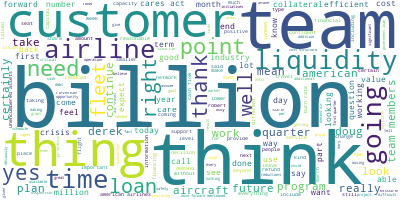

In [ ]:
plot_wordcloud(4)

In [ ]:
topic_list = ["apac", "emea", "america", "usa", "south america", "middle east", "europe", "china", "africa", "oceania", "737max", "max"]

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def topic(content_list):
      mentioned_topics = []
      main_topics = []
      temp_list = []

      for word in word_tokenize(content_list):
        for topic in topic_list:
          if word == topic:
            temp_list.append(topic)

      counted_topics = dict(Counter(temp_list))
      temp_dict = dict.fromkeys(temp_list, 0)
      temp_list = list(temp_dict)
      mentioned_topics.append(temp_list)

      keywords = []
      for key in counted_topics.keys():
        if counted_topics[key] > np.mean(list(counted_topics.values())):
          keywords.append(key)
      if len(keywords) != 0:
        main_topics.append(keywords)
      else:
        main_topics.append(temp_list)
    
      return mentioned_topics

In [ ]:
def get_people(content_list):
      final_names = []
      temp_list = []

      text = content_list
      doc = nlp(text)
      persons = [X.text for X in doc.ents if X.label_ == 'PERSON']
      persons_dict = dict.fromkeys(persons, 0)
      persons = list(persons_dict)

      full_names = []
      for person in persons: 
        if len(word_tokenize(person)) >= 2:
          string_name = re.sub(r"[^a-zA-Z0-9]+", ' ', person).strip()
          full_names.append(string_name)
    
      for person in persons:
        for name in full_names:
          tokens = word_tokenize(name)
          for n in range(len(tokens)):
            if person == tokens[n]:
              final_names.append(name)

      for name in full_names:
        final_names.append(name)

      return final_names

In [ ]:
data_subset = data_subset.groupby(['date'])['Transcript_clean'].apply(' '.join).reset_index()
data_subset['Transcript_clean'] = data_subset['Transcript_clean'].apply(lambda x : text_cleaner(x))
data_subset['topic'] = data_subset['Transcript_clean'].apply(lambda x : topic(x))
data_subset['names'] = data_subset['Transcript_clean'].apply(lambda x : get_people(x))

In [ ]:
data_subset

,date,Transcript_clean,topic,names
0,2018-04-23,thanks matt good morning everyone important ti...,[[america]],"[andrew discuss, andrew good morning, jamie an..."
1,2018-07-26,thanks amber good morning everyone thank joini...,[[america]],"[brad good morning, mike brad, cfo brandon, an..."
2,2019-01-24,thanks sia good afternoon everyone thank joini...,[[america]],"[andrew harrison, andrew brandon, andrew chanc..."
3,2019-04-25,thanks catherine good afternoon thank joining ...,"[[america, max]]","[brad tilden, echo brad, kevin brad, coo ben m..."
4,2019-04-26,good morning everyone welcome american airline...,"[[max, china, america]]","[max recertified, max answer, robert isom, may..."
5,2019-07-25,good morning everyone welcome american airline...,"[[max, europe, china, america]]","[dan mckenzie, dan shane, robert isom, dallas ..."
6,2019-10-24,thank good morning everyone welcome american a...,"[[max, america, china]]","[dan shane, max grounding, max aircraft, charl..."
7,2020-01-23,good morning everybody welcome american airlin...,"[[max, america, europe, africa, china]]","[doug parker, robert isom, robert follow, robe..."
8,2020-04-30,thanks cindy good morning everyone welcome ame...,"[[europe, america, china]]","[doug parker, david doug, jamie doug, mary sch..."
9,2020-07-23,thanks sarah good morning everyone welcome ame...,"[[america, europe, africa]]","[doug parker, doug good morning, david seymour..."


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# This function maps matrices to coordinates. The TF-IDF function maps 
# Frequency scores to matrices, which then need to be sorted to help us find our keywords. 

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [ ]:
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

In [ ]:
def get_keywords(content_list):
  keywords = []

  cv = CountVectorizer(max_df = 0.85)
  word_count_vector = cv.fit_transform(content_list)

  tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
  tfidf_transformer.fit(word_count_vector)

  feature_names = cv.get_feature_names()

  for i in range(len(content_list)):
    doc = content_list[i]
    tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
    sorted_items = sort_coo(tf_idf_vector.tocoo())
    keys = extract_topn_from_vector(feature_names,sorted_items,10)
    keywords.append(list(keys.keys()))
  
  return keywords

In [ ]:
data_subset = pd.concat([data_subset, pd.Series(get_keywords(data_subset['Transcript_clean'].tolist()))], axis = 1)

**Dataframe with keywords, topics, etc. obtained through the methods above, and corresponding to the dates of the transcripts.**

In [ ]:
data_subset = data_subset.dropna(axis=1)
data_subset = data_subset.rename(columns={0:"keywords"})
data_subset

,date,Transcript_clean,topic,names,keywords
0,2018-04-23,thanks matt good morning everyone important ti...,[[america]],"[andrew discuss, andrew good morning, jamie an...","[pss, slots, merger, sort, alaska, loyalty, sy..."
1,2018-07-26,thanks amber good morning everyone thank joini...,[[america]],"[brad good morning, mike brad, cfo brandon, an...","[integration, award, points, productivity, mer..."
2,2019-01-24,thanks sia good afternoon everyone thank joini...,[[america]],"[andrew harrison, andrew brandon, andrew chanc...","[andrew, actually, sort, fares, employees, cla..."
3,2019-04-25,thanks catherine good afternoon thank joining ...,"[[america, max]]","[brad tilden, echo brad, kevin brad, coo ben m...","[california, productivity, guests, sort, prici..."
4,2019-04-26,good morning everyone welcome american airline...,"[[max, china, america]]","[max recertified, max answer, robert isom, may...","[max, august, faa, cancellations, airworthy, d..."
5,2019-07-25,good morning everyone welcome american airline...,"[[max, europe, china, america]]","[dan mckenzie, dan shane, robert isom, dallas ...","[actually, max, points, margin, improvement, o..."
6,2019-10-24,thank good morning everyone welcome american a...,"[[max, america, china]]","[dan shane, max grounding, max aircraft, charl...","[max, chicago, free, sort, margin, brandon, op..."
7,2020-01-23,good morning everybody welcome american airlin...,"[[max, america, europe, africa, china]]","[doug parker, robert isom, robert follow, robe...","[max, gap, settlement, margin, factor, shareho..."
8,2020-04-30,thanks cindy good morning everyone welcome ame...,"[[europe, america, china]]","[doug parker, david doug, jamie doug, mary sch...","[loan, liquidity, cares, masks, act, collatera..."
9,2020-07-23,thanks sarah good morning everyone welcome ame...,"[[america, europe, africa]]","[doug parker, doug good morning, david seymour...","[crisis, burn, york, liquidity, june, vasu, do..."


In [ ]:
cluster_keywords = []
cluster_number = []

In [ ]:
# This function checks the clustering algorithm against various 'k' parameters 
# to find the optimal value of 'k'. 

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, 
                                   init_size=1024, 
                                   batch_size=2048,
                                   random_state=20).fit(data).inertia_)
        
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

In [ ]:
# Getting keywords from content lists, 
# to help with categorizing topic clusters later

def get_top_keywords(data, clusters, labels, n_terms):
  df = pd.DataFrame(data.todense()).groupby(clusters).mean()
  for i,r in df.iterrows():
    cluster_keywords.append(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

In [ ]:
# Applying clustering to content lists for topic modeling

def themes(content_list):

  cv = CountVectorizer(max_df = 0.85)
  word_count_vector = cv.fit_transform(content_list)

  tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
  tfidf_transformer.fit(word_count_vector)

  feature_names = cv.get_feature_names()
  vector = tfidf_transformer.transform(cv.transform(content_list))

  find_optimal_clusters(vector,5)

  clusters = MiniBatchKMeans(n_clusters=5, init_size=1024, batch_size=2048, random_state=20).fit_predict(vector)
  for cluster in clusters:
    cluster_number.append(int(cluster))
  
  get_top_keywords(vector, clusters, cv.get_feature_names(), 20)

In [ ]:
themes(data_subset['Transcript_clean'].tolist())

In [ ]:
cluster_number

[1, 1, 0, 1, 2, 2, 2, 2, 4, 3, 3, 3, 3]

In [ ]:
cluster_keywords

['fare,afternoon,synergies,christmas,partners,brad,owners,alaska,adjusted,virgin,points,loyalty,integration,rasm,class,employees,fares,sort,actually,andrew',
 'low,virgin,ben,pss,adjustments,synergies,pricing,shane,brandon,integration,alaska,points,guests,productivity,fares,merger,andrew,loyalty,california,sort',
 'reliability,gap,pretax,operational,faa,record,domestic,items,improvement,derek,shareholders,points,grounding,factor,dfw,free,robert,actually,margin,max',
 'haul,support,loan,york,jetblue,testing,psp,perspective,crisis,indeed,covid,vasu,doug,robert,derek,international,recovery,burn,liquidity,pandemic',
 'tranche,outs,financing,reasonable,assets,treasury,grant,support,leaves,ato,crisis,doug,burn,derek,collateral,act,masks,cares,liquidity,loan']

In [ ]:
competitors = ['virgin', 'alaska', 'jetblue']
financial = ['synergies', 'pretax', 'margin', 'rasm', 'fares', 'shareholding']
covid = ['covid', 'liquidity', 'loan', 'grounding', 'support', 'pandemic']

topic_dict = {}
topic_categories= []
cat_list = [competitors, financial, covid]

for i in range(len(cluster_keywords)):
  temp_list=[]
  for n in nltk.word_tokenize(cluster_keywords[i]):
    for item in cat_list:
      if n in item:
        temp_list.append(item[0])
  
  temp_dict=dict.fromkeys(temp_list,0)
  temp_list=list(temp_dict)

  topic_dict[i] = temp_list

for num in cluster_number:
  topic_categories.append(topic_dict[num])

In [ ]:
topic_categories

[['virgin', 'synergies'],
 ['virgin', 'synergies'],
 ['synergies', 'virgin'],
 ['virgin', 'synergies'],
 ['synergies', 'covid'],
 ['synergies', 'covid'],
 ['synergies', 'covid'],
 ['synergies', 'covid'],
 ['covid'],
 ['covid', 'virgin'],
 ['covid', 'virgin'],
 ['covid', 'virgin'],
 ['covid', 'virgin']]

# Grammatical Extraction with PoS and Matcher

**Breaking this down by whole sentences to analyse the contents, context and grammatical structure through PoS.** The initial step goes back to the beginning where we only applied a light text cleaner to preserve sentence and grammatical structures. We now split the text into sentences, which is done through detection of full stops, but with some conditions in relation to decimal points. Can be refined further to perhaps detect single letters before in the event of abbreviated names.

In [18]:
def sentences(text):
    text = re.split("[\.?!]\s+", text)
    clean_sent = []
    for sent in text:
        clean_sent.append(sent)
    return clean_sent

In [19]:
data['sent'] = data['Transcript_clean'].apply(sentences)
df2 = pd.DataFrame(columns=['Sent', 'Date', 'Len'])

In [20]:
# Alternatively, compare against the gensim split_sentences:
data['sent2'] = data['Transcript_clean'].apply(split_sentences)

Both version clearly works better than following just full stops, where they can both detect when the full stop is a decimal. But, they both struggle on names where there is an abbreviation.

In [26]:
data['sent2'][15]

['It will be harder to do.',
 "But I mean I can give you what the EPS impact    I mean we said it $0.60 for where we're at.",
 'The    by month or by quarter, right now in the second quarter, we said it was a $350 million impact.',
 'We had $50 million in the first quarter, approximately $185 million in the second quarter and approximately $115 million in the third quarter.',
 'So I would say the $185 million in the second quarter is a full quarter.',
 'So that a number that there the whole time.',
 'But that is the summer and that the peak.',
 'So it might be a little bit higher than if it continued into August, September, October.',
 'It might have a little bit less effect where we probably have a little bit more room.',
 'I mean the reason we took it down to August 19 is that when the end of the summer is and when the peak is.',
 'So we may have a little bit more room in August and September to cover some of the flying.',
 'So I think that the best we can do right now from that effe

In [27]:
data['sent'][15]

[' It will be harder to do',
 "But I mean I can give you what the EPS impact    I mean we said it $0.60 for where we're at",
 'The    by month or by quarter, right now in the second quarter, we said it was a $350 million impact',
 'We had $50 million in the first quarter, approximately $185 million in the second quarter and approximately $115 million in the third quarter',
 'So I would say the $185 million in the second quarter is a full quarter',
 'So that a number that there the whole time',
 'But that is the summer and that the peak',
 'So it might be a little bit higher than if it continued into August, September, October',
 'It might have a little bit less effect where we probably have a little bit more room',
 'I mean the reason we took it down to August 19 is that when the end of the summer is and when the peak is',
 'So we may have a little bit more room in August and September to cover some of the flying',
 'So I think that the best we can do right now from that effect',
 'But

In [29]:
row_list = []

for i in range(len(data)):
    for sent in data.loc[i, 'sent']:
        wordcount = len(sent.split())
        date = data.loc[i, 'date']
        comp = data.loc[i, 'company']
        dict1 = {'Date': date, 'Sent': sent, 'Len': wordcount, 'Comp': comp}
        row_list.append(dict1)

data2 = pd.DataFrame(row_list)
print(data2.head(10))

        Date                                               Sent  Len Comp
0 2019-04-26   Good morning, everyone, and welcome to the Am...   16  AAL
1 2019-04-26  With us in the room this morning is Doug Parke...   23  AAL
2 2019-04-26  Also in the room for question and answer sessi...   46  AAL
3 2019-04-26  Like we normally do, Doug will start the call ...   16  AAL
4 2019-04-26  Derek will then walk us through the details on...   26  AAL
5 2019-04-26  Robert will then follow with commentary on the...   12  AAL
6 2019-04-26  And then after we hear from those comments, we...   23  AAL
7 2019-04-26  Before we begin, we must state that today call...   35  AAL
8 2019-04-26  These statements represent our predictions and...   25  AAL
9 2019-04-26  Information about some of these risk and uncer...   48  AAL


In [31]:
import spacy
from spacy.matcher import Matcher
from spacy import displacy
from IPython.display import Image, display
nlp = spacy.load('en_core_web_sm', disable=['ner', 'textcat'])

## Information Extraction – Finding Keywords and using Dependencies

SpaCy’s Matcher class. It allows us to match a sequence of words based on certain patterns and using regex to find sentences that only contain keywords. First approach - creating a function to find words with Matcher. Simplist approach to searching by grammatical structure. Filter dataframe to isolate sentences where these keywords appear.

In [32]:
# data2['Cleaned_sent'] = data2['Sent'].apply(lambda x : text_cleaner(x))

In [33]:
def word_detect(text):
  
    patterns = [r'\b(?i)' + 'profit' + r'\b',
                r'\b(?i)' + 'profitability' + r'\b',
                r'\b(?i)' + 'revenue' + r'\b',
                r'\b(?i)' + 'revenues' + r'\b',
                r'\b(?i)' + 'margins' + r'\b', 
                r'\b(?i)' + 'returns' + r'\b', 
                r'\b(?i)' + 'income' + r'\b', 
                r'\b(?i)' + 'cashflow' + r'\b', 
                r'\b(?i)' + 'cash flow' + r'\b']

    output = []
    flag = 0

    for pat in patterns:
        if re.search(pat, text) != None:
            flag = 1
            break
    return flag

In [34]:
data2['Word_detect'] = data2['Sent'].apply(word_detect)

In [37]:
data2 = data2[data2['Len'] > 8]

In [38]:
data2

,Date,Sent,Len,Comp,Word_detect
0,2019-04-26,"Good morning, everyone, and welcome to the Am...",16,AAL,0
1,2019-04-26,With us in the room this morning is Doug Parke...,23,AAL,0
2,2019-04-26,Also in the room for question and answer sessi...,46,AAL,1
3,2019-04-26,"Like we normally do, Doug will start the call ...",16,AAL,0
4,2019-04-26,Derek will then walk us through the details on...,26,AAL,0
...,...,...,...,...,...
8460,2019-10-24,"Dan, I my prepared remarks were more aroun...",9,ALK,0
8461,2019-10-24,And we don't like to get into the details of s...,12,ALK,0
8462,2019-10-24,But what I will tell you is that this flying h...,25,ALK,0
8463,2019-10-24,And so we are seeing improved profitability ac...,21,ALK,1


In the pattern, each dictionary in the list matches a unique word. In this case, the name of the plan starts with a determiner and ends with the word in the pattern list. In between, we search for proper nouns and compounds.

In [48]:
def org_compound(text):
    org = []

    doc = nlp(text)
    prog_list = ['plan', 'structure',
                 'budget', 'organisation', 'cabin']
    
    pattern = [{'POS': 'DET'},
               {'POS': 'PROPN', 'DEP': 'compound'},
               {'POS': 'PROPN', 'DEP': 'compound'},
               {'POS': 'PROPN', 'OP': '?'},
               {'POS': 'PROPN', 'OP': '?'},
               {'POS': 'PROPN', 'OP': '?'},
               {'LOWER': {'IN': prog_list}, 'OP': '+'}
               ]

    # Matcher class object
    matcher = Matcher(nlp.vocab)
    matcher.add("matching", [pattern])
    matches = matcher(doc)
    
    for match_id, start, end in matches:
        
        if doc[start].pos_ == 'DET':
            start = start + 1
        
        span = doc[start:end]
        span = span.text

        if (len(org) != 0) and (org[-1] in span):
            org[-1] = span
        else:
            org.append(span)

    return org

In [ ]:
data2['Word_detect'] = data2['Sent'].apply(org_compound)

In [52]:
data2.reset_index(inplace=True)

**Printing some examples of the whole sentence that contains this pattern.**

In [53]:
for i in range(len(data2)):
    if len(data2.loc[i,'Word_detect']) != 0:
        print('->',data2.loc[i,'Date'],',',data2.loc[i,'Word_detect'],':')
        print(data2.loc[i,'Sent'])

-> 2021-04-22 00:00:00 , ['Green Flag Plan'] :
I mean the whole point to the earlier remarks about the Green Flag Plan is to deliver an airline that can outperform in the future, and we think we've done that, but the proof will be when we do.
-> 2019-01-24 00:00:00 , ['First Class cabin'] :
And also, with all these new regional aircraft, they're actually adding    I think our First Class ASMs are actually up 8%    excuse me, our revenues are up 8% for the First Class cabin, 6% growth
-> 2019-10-24 00:00:00 , ['Premium Class cabin', 'First Class cabin'] :
With that Premium Class cabin, the First Class cabin, which has great demand on a Hawaii flights and just the service we provide
-> 2019-10-24 00:00:00 , ['First Class cabin'] :
We're taking the First Class cabin from 8 to 12


The limitation of the previous approach is still around the relatively restrictive pattern of nouns preceding certain words, which Spacy might not detect. Therefore consider subtrees, i.e. by matching against entries in the pattern, can use token.subtree to find the dependencies that fit a grammatical pattern. E.g. in a dependency graph, something like "loyalty programme" or "transformation initiative" or "New Horizons Plan", etc. could be extracted by looking at a pattern of the last word and finding the sub-tree of that word.

In [ ]:
def org_subtree(text):

    patterns = [r'\b(?i)' + 'programme' + r'\b',
                r'\b(?i)' + 'business plan' + r'\b',
                r'\b(?i)' + 'initiative' + r'\b',
                r'\b(?i)' + 'strategy' + r'\b']
    org = []

    doc = nlp(text)
    flag = 0
    for pat in patterns:
        if re.search(pat, text) != None:
            flag = 1
            break
    if flag == 0:
        return org

    for token in doc:
        for pat in patterns:
            if re.search(pat, token.text) != None:

                word = ''
                # iterating over token subtree
                for node in token.subtree:
                    if (node.pos_ == 'PROPN'):
                        word += node.text + ' '

                if len(word) != 0:
                    org.append(word)

    return org

In [ ]:
data2['Org_detect'] = data2['Cleaned_sent'].apply(org_subtree)

In [ ]:
count = 0
for i in range(len(data2)):
    if len(df2.loc[i,'Org_detect']) != 0:
        count += 1
print(count)

## Understanding the Structure and Pattern of Texts

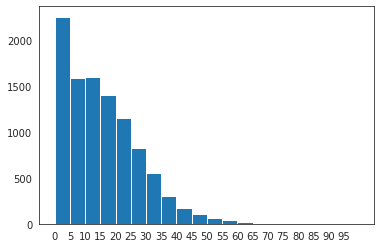

In [ ]:
plt.hist(data2['Len'],bins=20,range=[0,100])
plt.xticks(np.arange(0,100,5));

### Generalised PoS Pattern Extraction

Add more rules to populate dataframe as appropriate. The approach is basically to generate columns that contain the phrase generated by the respective rule. Then dataframe can be filtered by Boolean for whether one rule or multiple rules are satisfied by that sentence. And finally, each phrase can be broken down word-by-word for graphing or statistical analysis.

In [55]:
def rule_verb(text):
    
    doc = nlp(text)
    sent = []
    for token in doc:
        if (token.pos_=='VERB'):
            phrase = ''
            
            for sub_tok in token.lefts:
                if (sub_tok.dep_ in ['nsubj','nsubjpass']) and (sub_tok.pos_ in ['NOUN','PROPN','PRON']):
                    phrase += sub_tok.text
                    phrase += ' '+token.lemma_ 

                    for sub_tok in token.rights:
                        if (sub_tok.dep_ in ['dobj']) and (sub_tok.pos_ in ['NOUN','PROPN']):
                                    
                            phrase += ' '+sub_tok.text
                            sent.append(phrase)
            
    return sent

In [56]:
def rule_prepositions(text):
  
    doc = nlp(text)
    sent = []
    for token in doc:
        if token.pos_=='ADP':
            phrase = ''
            
            if token.head.pos_=='NOUN':
                
                phrase += token.head.text
                phrase += ' '+token.text

                for right_tok in token.rights:
                    if (right_tok.pos_ in ['NOUN','PROPN']):
                        phrase += ' '+right_tok.text
                
                if len(phrase) > 2:
                    sent.append(phrase)
                
    return sent

In [57]:
def generalised_extractor(data):

    row_list = []

    for i in range(len(data)):
        
        sent = data.loc[i,'Sent']
        date = data.loc[i,'Date']
        comp = data.loc[i,'Comp']

        output1 = rule_verb(sent)
        output2 = rule_prepositions(sent)
        dict1 = {'Date':date, 'Sent':sent, 'Verb':output1, 'Prep':output2, 'Comp':comp}
        row_list.append(dict1)
        
    data_out = pd.DataFrame(row_list)
    return data_out

In [59]:
data_output = generalised_extractor(data2)

In [65]:
data_output = data_output[(data_output["Verb"].str.len() != 0)]
data_output = data_output[(data_output["Prep"].str.len() != 0)]
data_output.reset_index(inplace=True)
data_output

,index,Date,Sent,Verb,Prep,Comp
0,3,2019-04-26,"Like we normally do, Doug will start the call ...",[Doug start call],[overview of results],AAL
1,6,2019-04-26,"And then after we hear from those comments, we...",[we open call],"[call for questions, questions from media]",AAL
2,7,2019-04-26,"Before we begin, we must state that today call...",[call contain statements],[forecast of capacity],AAL
3,10,2019-04-26,Before I give more details on our financial pe...,[I give details],[update on fleet],AAL
4,11,2019-04-26,"As you are aware, on March 7, 2019, we announc...",[we announce removal],"[removal of aircraft, removal from service, se...",AAL
...,...,...,...,...,...,...
1127,6399,2019-10-24,"So if anything, we would see the benefits from...",[we see benefits],[benefits from],ALK
1128,6406,2019-10-24,And if we can grow 4% to 6% per year for over ...,[we achieve goals],"[% per year, lot of growth]",ALK
1129,6408,2019-10-24,And we feel like that the right growth rate fo...,[we feel rate],[rate for],ALK
1130,6426,2019-10-24,In terms of the inning I think we've got a f...,[we get quarter],[terms of inning],ALK


In [ ]:
def output_percentage(df, out_col):
    
    result = 0
    for out in df[out_col]:
        if len(out) != 0:
            result += 1
    per = result / len(df)
    per *= 100
    
    return per

In [69]:
rulesdict = dict()
ruleslist = []

for i in range(len(data_output)):
    
    sentence = data_output.loc[i,'Sent']
    date = data_output.loc[i,'Date']
    output1 = data_output.loc[i,'Verb']
    output2 = data_output.loc[i,'Prep']
    comp = data_output.loc[i,'Comp']
    
    for o1 in output1:
        for o2 in output2:
        
            # separate subject, prep and object
            n1, v, n2 = o1.split()[:1], o1.split()[1], o1.split()[2:]
            n3, p, n4 = o2.split()[:1], o2.split()[1], o2.split()[2:]

            # simple switch we for name of company
            noun1 = []
            for word in n1:
                if word in ["We", "we", "I"]:
                    noun1.append(comp)
                else: noun1.append(word)
            
            # append to list, along with the sentence
            rulesdict = {'Sent':sentence,'Date':date,'Comp':comp,'Noun1':noun1,'Verb':v,'Noun2':n2,
                        'Noun3':n3,'Prep':p,'Noun4':n4}
            ruleslist.append(rulesdict)

data_output2 = pd.DataFrame(ruleslist)

In [70]:
data_output2

,Sent,Date,Comp,Noun1,Verb,Noun2,Noun3,Prep,Noun4
0,"Like we normally do, Doug will start the call ...",2019-04-26,AAL,[Doug],start,[call],[overview],of,[results]
1,"And then after we hear from those comments, we...",2019-04-26,AAL,[AAL],open,[call],[call],for,[questions]
2,"And then after we hear from those comments, we...",2019-04-26,AAL,[AAL],open,[call],[questions],from,[media]
3,"Before we begin, we must state that today call...",2019-04-26,AAL,[call],contain,[statements],[forecast],of,[capacity]
4,Before I give more details on our financial pe...,2019-04-26,AAL,[AAL],give,[details],[update],on,[fleet]
...,...,...,...,...,...,...,...,...,...
2201,And if we can grow 4% to 6% per year for over ...,2019-10-24,ALK,[ALK],achieve,[goals],[%],per,[year]
2202,And if we can grow 4% to 6% per year for over ...,2019-10-24,ALK,[ALK],achieve,[goals],[lot],of,[growth]
2203,And we feel like that the right growth rate fo...,2019-10-24,ALK,[ALK],feel,[rate],[rate],for,[]
2204,In terms of the inning I think we've got a f...,2019-10-24,ALK,[ALK],get,[quarter],[terms],of,[inning]


**Miscellaneous; filtering**

In [ ]:
sort = sorted(verb_dict.items(), key = lambda d:(d[1],d[0]), reverse=True)
sort[:10]

In [72]:
data_output2[data_output2['Verb']=='provide']

,Sent,Date,Comp,Noun1,Verb,Noun2,Noun3,Prep,Noun4
266,"To Robert, on the JBA with Qantas, I recall a ...",2019-07-25,AAL,[you],provide,[size],[venture],with,[Airlines]
267,"To Robert, on the JBA with Qantas, I recall a ...",2019-07-25,AAL,[you],provide,[size],[revenue],between,[]
398,Derek will provide some high level CASM estima...,2019-10-24,AAL,[Derek],provide,[estimates],[details],on,[call]
426,The steady stream of customer focused deliveri...,2019-10-24,AAL,[stream],provide,[experience],[stream],of,"[customer, deliveries]"
427,The steady stream of customer focused deliveri...,2019-10-24,AAL,[stream],provide,[experience],[experience],for,[customers]
428,The steady stream of customer focused deliveri...,2019-10-24,AAL,[stream],provide,[experience],[results],for,[shareholders]
620,Due to material uncertainty around the groundi...,2020-01-23,AAL,[AAL],provide,[guidance],[uncertainty],around,[grounding]
621,Due to material uncertainty around the groundi...,2020-01-23,AAL,[AAL],provide,[guidance],[grounding],of,[MAX]
680,CARES provides the industry the breathing room...,2020-04-30,AAL,[CARES],provide,[room],[parts],of,[crisis]
745,These funds as well as relief on various taxes...,2020-04-30,AAL,[funds],provide,[support],[relief],on,[taxes]


In [ ]:
# support verb
data_output2[data_output2['Verb']=='make']

,Sent,Date,Noun1,Verb,Noun2
16,We made contributions of $364 million to our ...,2019-04-26,[We],make,[contributions]
25,"And as Derek mentioned, on April 14, we made ...",2019-04-26,[we],make,[decision]
30,We've made steady improvements in our interna...,2019-04-26,[We],make,[improvements]
52,"Also, as a reminder, in 2018, we made a big i...",2019-04-26,[we],make,[investment]
74,And when that when they make that determin...,2019-04-26,[they],make,[determination]
...,...,...,...,...,...
1999,So we are just all in focusing on the guest e...,2019-07-25,[it],make,[difference]
2074,"Besides premium seating, we've made significa...",2019-10-24,[we],make,[investments]
2080,"Before I move to guidance, I'd like to highli...",2019-10-24,[we],make,[adjustments]
2100,Our strong performance this year has also all...,2019-10-24,[us],make,[changes]


In [ ]:
sort = sorted(prep_dict.items(), key = lambda d:(d[1],d[0]), reverse=True)
sort[:10]

[('of', 2402),
 ('in', 802),
 ('for', 534),
 ('on', 375),
 ('to', 321),
 ('with', 228),
 ('from', 146),
 ('over', 115),
 ('at', 103),
 ('per', 68)]

In [ ]:
# 'against'
data_output2[data_output2['Preposition']=='per']

,Sent,Date,Noun1,Preposition,Noun2
24,We have now removed all 737 MAX flying from o...,2019-04-26,flights,per,[day]
73,"For the full year, we now expect that our 201...",2019-04-26,cost,per,[ASM]
88,"For revenue, we expect that our total revenue...",2019-04-26,revenue,per,[ASM]
96,"25 per share, we now anticipate that our earni...",2019-04-26,earnings,per,[share]
100,"25 per share, we now anticipate that our earni...",2019-04-26,earnings,per,[share]
...,...,...,...,...,...
5294,"Aggregate Air Group productivity, which we me...",2019-10-24,guests,per,[FTE]
5385,Are you looking at ASMs per gallon or what yo...,2019-10-24,ASMs,per,[gallon]
5386,At ASMs per gallon,2019-10-24,ASMs,per,[gallon]
5503,And if we can grow 4% to 6% per year for over...,2019-10-24,%,per,[year]
